#Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from geopy import distance

#Importing Data

In [3]:
df = pd.read_csv('YourCabs_training.csv')

In [4]:
data=df.drop(['Car_Cancellation','Cost_of_error'],axis=1) #Dropping Target columns

In [5]:
target=df[['Car_Cancellation']]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   43431 non-null  int64  
 1   user_id              43431 non-null  int64  
 2   vehicle_model_id     43431 non-null  int64  
 3   package_id           7550 non-null   float64
 4   travel_type_id       43431 non-null  int64  
 5   from_area_id         43343 non-null  float64
 6   to_area_id           34293 non-null  float64
 7   from_city_id         16345 non-null  float64
 8   to_city_id           1588 non-null   float64
 9   from_date            43431 non-null  object 
 10  to_date              25541 non-null  float64
 11  online_booking       43431 non-null  int64  
 12  mobile_site_booking  43431 non-null  int64  
 13  booking_created      43431 non-null  object 
 14  from_lat             43338 non-null  float64
 15  from_long            43338 non-null 

In [7]:
data.isnull().mean()

id                     0.000000
user_id                0.000000
vehicle_model_id       0.000000
package_id             0.826161
travel_type_id         0.000000
from_area_id           0.002026
to_area_id             0.210403
from_city_id           0.623656
to_city_id             0.963436
from_date              0.000000
to_date                0.411918
online_booking         0.000000
mobile_site_booking    0.000000
booking_created        0.000000
from_lat               0.002141
from_long              0.002141
to_lat                 0.210403
to_long                0.210403
dtype: float64

# Data Cleaning

In [8]:
data=data.drop(['id','user_id','package_id','to_area_id','from_city_id','to_city_id','to_date'],axis=1)
#Dropping Identity columns
#Dropping on null percentage >40
#Dropping to_area_id as of no scope

In [9]:
data['vehicle_model_id'].value_counts(normalize=True)*100

12    73.355437
85     5.542124
89     5.505284
65     4.402385
28     3.918860
24     3.439939
87     1.300914
90     0.718381
23     0.683843
86     0.283208
10     0.239460
64     0.195713
54     0.168083
17     0.092100
91     0.057563
30     0.032235
36     0.020723
13     0.016118
1      0.004605
43     0.004605
72     0.004605
14     0.002303
76     0.002303
75     0.002303
39     0.002303
70     0.002303
69     0.002303
Name: vehicle_model_id, dtype: float64

In [10]:
data=data.drop(['vehicle_model_id'],axis=1) #Dropping as single value has more percentage

In [11]:
data.head()

,travel_type_id,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long
0,2,83.0,1/1/2013 2:00,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750
1,2,1010.0,1/1/2013 9:00,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640
2,2,1301.0,1/1/2013 3:30,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766
3,2,768.0,1/1/2013 5:45,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140
4,2,1365.0,1/1/2013 9:00,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720


#Data Transforming

In [12]:
print(data[data['from_lat'] == data['from_lat'].median()]['from_area_id'].max())
print(data['from_lat'].median())
print(data['from_long'].median())

1044.0
12.968887
77.63575


In [13]:
data['from_lat'] = data['from_lat'].fillna(data['from_lat'].median())
data['from_long'] = data['from_long'].fillna(data['from_long'].median())

In [14]:
data['from_area_id'] = data['from_area_id'].fillna(data[data['from_lat'] == data['from_lat'].median()]['from_area_id'].max())

In [15]:
data['to_lat'] = data['to_lat'].fillna(df.groupby('from_area_id')['to_lat'].transform('median'))
#Fill na with median for Continuous data and mode for Discrete data

In [16]:
data['to_long'] = data['to_long'].fillna(df.groupby('from_area_id')['to_long'].transform('median'))
#Fill na with median for Continuous data and mode for Discrete data

In [17]:
data[data['to_lat'].isnull()].head()

,travel_type_id,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long
2158,1,483.0,1/25/2013 6:00,1,0,1/24/2013 15:32,12.953020,77.56333,NaN,NaN
3945,1,1397.0,2/10/2013 16:30,1,0,2/10/2013 13:26,12.968887,77.63575,NaN,NaN
4912,1,1397.0,2/23/2013 6:30,1,0,2/19/2013 21:29,12.968887,77.63575,NaN,NaN
5144,1,1397.0,2/22/2013 13:30,1,0,2/22/2013 10:22,12.968887,77.63575,NaN,NaN
5970,1,1397.0,3/4/2013 7:00,0,0,3/2/2013 17:48,12.968887,77.63575,NaN,NaN


In [18]:
data[data['to_lat'].isnull()]['from_area_id'].value_counts()

1397.0    90
1396.0     3
173.0      2
17.0       2
802.0      1
215.0      1
1080.0     1
1265.0     1
1215.0     1
1164.0     1
178.0      1
483.0      1
Name: from_area_id, dtype: int64

In [19]:
print(data['to_lat'].median())
print(data['to_long'].median())

12.98999
77.649047


In [20]:
data['to_lat'] = data['to_lat'].fillna(data['to_lat'].median())
data['to_long'] = data['to_long'].fillna(data['to_long'].median())

In [21]:
data[data['from_area_id']==571.0].head(10)

,travel_type_id,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long
6,1,571.0,1/1/2013 9:45,0,0,1/1/2013 9:21,12.95185,77.69642,12.986284,77.65530
43,2,571.0,1/2/2013 3:00,0,0,1/1/2013 19:00,12.95185,77.69642,13.199560,77.70688
78,2,571.0,1/3/2013 17:15,1,0,1/2/2013 9:31,12.95185,77.69642,13.199560,77.70688
156,2,571.0,1/4/2013 8:00,0,0,1/3/2013 10:29,12.95185,77.69642,13.028530,77.54625
159,2,571.0,1/4/2013 4:45,1,0,1/3/2013 13:00,12.95185,77.69642,12.976770,77.57270
212,3,571.0,1/4/2013 13:15,0,0,1/4/2013 8:36,12.95185,77.69642,12.986284,77.65530
225,2,571.0,1/4/2013 13:30,0,0,1/4/2013 10:32,12.95185,77.69642,13.199560,77.70688
261,2,571.0,1/4/2013 22:00,0,0,1/4/2013 18:07,12.95185,77.69642,12.907960,77.62418
278,3,571.0,1/5/2013 10:00,0,0,1/4/2013 20:19,12.95185,77.69642,12.986284,77.65530
297,2,571.0,1/5/2013 10:30,0,0,1/5/2013 8:59,12.95185,77.69642,13.022390,77.59492


In [22]:
data.isnull().mean()

travel_type_id         0.0
from_area_id           0.0
from_date              0.0
online_booking         0.0
mobile_site_booking    0.0
booking_created        0.0
from_lat               0.0
from_long              0.0
to_lat                 0.0
to_long                0.0
dtype: float64

In [23]:
data.shape

(43431, 10)

In [24]:
traveltype = pd.get_dummies(data['travel_type_id'],drop_first=True)
#One Hot Encoding if number of distinct values is more than 5
#Label Encoding if number of distinct values is less than 5

In [25]:
data = pd.concat([data,traveltype],axis=1)
data = data.drop(['travel_type_id'],axis=1)

In [26]:
data.rename(columns={2:'traveltype_pointtopoint',3:'traveltype_hourly'},inplace=True)

In [27]:
def cal_distance(from_lat,from_long,to_lat,to_long):
  return distance.distance((from_lat,from_long),(to_lat,to_long)).km

In [28]:
data['distance'] = data.apply(lambda row: cal_distance(row['from_lat'],row['from_long'],row['to_lat'],row['to_long']),axis=1)

In [29]:
data[data['distance'] < 0]

,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,traveltype_pointtopoint,traveltype_hourly,distance


In [30]:
data = data.drop(['from_lat','from_long','to_lat','to_long'],axis=1)

In [31]:
data['from_date_dt'] = pd.to_datetime(data['from_date']).dt.strftime('%m/%d/%Y')
data['from_time_tm'] = pd.to_datetime(data['from_date']).dt.strftime('%H:%M')
data['booking_created_dt'] = pd.to_datetime(data['booking_created']).dt.strftime('%m/%d/%Y')
data['booking_created_tm'] = pd.to_datetime(data['booking_created']).dt.strftime('%H:%M')

In [32]:
data['from_date_day'] = pd.to_datetime(data['from_date_dt']).dt.day_name()
data['booking_created_day'] = pd.to_datetime(data['booking_created_dt']).dt.day_name()
data['from_date_month'] = pd.to_datetime(data['from_date_dt']).dt.month_name()
data['booking_created_month'] = pd.to_datetime(data['booking_created_dt']).dt.month_name()
data['from_date_week'] = np.where((data['from_date_day']=='Saturday') | (data['from_date_day']=='Sunday'),'Weekend','Weekday',)
data['booking_created_week'] = np.where((data['booking_created_day']=='Saturday') | (data['booking_created_day']=='Sunday'),'Weekend','Weekday',)

In [33]:
cond = [(pd.to_datetime(data['from_time_tm']).dt.hour.between(5, 8)),
        (pd.to_datetime(data['from_time_tm']).dt.hour.between(9, 12)),
        (pd.to_datetime(data['from_time_tm']).dt.hour.between(13, 16)),
        (pd.to_datetime(data['from_time_tm']).dt.hour.between(17, 20)),
        ((pd.to_datetime(data['from_time_tm']).dt.hour.between(21, 24)) | (pd.to_datetime(data['from_time_tm']).dt.hour==0)),
        (pd.to_datetime(data['from_time_tm']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']
data['from_date_session'] = np.select(cond,values)

In [34]:
cond = [(pd.to_datetime(data['booking_created_tm']).dt.hour.between(5, 8)),
        (pd.to_datetime(data['booking_created_tm']).dt.hour.between(9, 12)),
        (pd.to_datetime(data['booking_created_tm']).dt.hour.between(13, 16)),
        (pd.to_datetime(data['booking_created_tm']).dt.hour.between(17, 20)),
        ((pd.to_datetime(data['booking_created_tm']).dt.hour.between(21, 24)) | (pd.to_datetime(data['booking_created_tm']).dt.hour==0)),
        (pd.to_datetime(data['booking_created_tm']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']
data['booking_created_session'] = np.select(cond,values)

In [35]:
data['time_diff'] = (pd.to_datetime(data['from_date']) - pd.to_datetime(data['booking_created'])).astype('timedelta64[m]')

In [36]:
data[data['time_diff'] < 0].head()

,from_area_id,from_date,online_booking,mobile_site_booking,booking_created,traveltype_pointtopoint,traveltype_hourly,distance,from_date_dt,from_time_tm,...,booking_created_tm,from_date_day,booking_created_day,from_date_month,booking_created_month,from_date_week,booking_created_week,from_date_session,booking_created_session,time_diff
1763,1298.0,1/20/2013 14:15,0,0,1/20/2013 15:01,0,1,8.482630,01/20/2013,14:15,...,15:01,Sunday,Sunday,January,January,Weekend,Weekend,Afternoon,Afternoon,-46.0
2990,393.0,2/1/2013 9:45,0,0,2/1/2013 13:18,0,1,28.576256,02/01/2013,09:45,...,13:18,Friday,Friday,February,February,Weekday,Weekday,Morning,Afternoon,-213.0
4228,571.0,2/13/2013 18:00,0,0,2/13/2013 18:29,0,1,5.866543,02/13/2013,18:00,...,18:29,Wednesday,Wednesday,February,February,Weekday,Weekday,Evening,Evening,-29.0
5303,1068.0,2/23/2013 18:00,0,0,2/23/2013 18:03,0,1,3.547502,02/23/2013,18:00,...,18:03,Saturday,Saturday,February,February,Weekend,Weekend,Evening,Evening,-3.0
6106,1010.0,3/4/2013 0:30,0,0,3/4/2013 2:00,0,1,10.133543,03/04/2013,00:30,...,02:00,Monday,Monday,March,March,Weekday,Weekday,Night,Late Night,-90.0


In [37]:
data[data['time_diff'] < 0]['time_diff'].count()

42

In [38]:
data = data.drop(['from_date','booking_created'],axis=1)

In [39]:
data = data.drop(['from_date_dt','from_time_tm','booking_created_dt','booking_created_tm'],axis=1)

In [40]:
data_merged = pd.concat([data,target],axis=1,join='inner')
data['from_area_id'] = round(data_merged.groupby('from_area_id')['Car_Cancellation'].sum()/data_merged.groupby('from_area_id')['Car_Cancellation'].count(),2)
data['from_area_id'].replace(np.nan,0,inplace=True)

In [41]:
cond = [(data['from_area_id'].astype('float').between(0,0.33)),
        (data['from_area_id'].astype('float').between(0.34,0.66)),
        (data['from_area_id'].astype('float').between(0.67,1.0))]
values = ['Low Cancellation','Medium Cancellation','High Cancellation']
data['from_area_id'] = np.select(cond,values)

#Data Visualization

In [42]:
data.head()

,from_area_id,online_booking,mobile_site_booking,traveltype_pointtopoint,traveltype_hourly,distance,from_date_day,booking_created_day,from_date_month,booking_created_month,from_date_week,booking_created_week,from_date_session,booking_created_session,time_diff
0,Low Cancellation,0,0,1,0,3.980687,Tuesday,Tuesday,January,January,Weekday,Weekday,Late Night,Late Night,21.0
1,Low Cancellation,0,0,1,0,14.004432,Tuesday,Tuesday,January,January,Weekday,Weekday,Morning,Late Night,395.0
2,Low Cancellation,0,0,1,0,12.648909,Tuesday,Tuesday,January,January,Weekday,Weekday,Late Night,Late Night,22.0
3,Low Cancellation,0,0,1,0,9.534596,Tuesday,Tuesday,January,January,Weekday,Weekday,Early Morning,Late Night,66.0
4,Low Cancellation,0,0,1,0,14.655467,Tuesday,Tuesday,January,January,Weekday,Weekday,Morning,Early Morning,67.0


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   from_area_id             43431 non-null  object 
 1   online_booking           43431 non-null  int64  
 2   mobile_site_booking      43431 non-null  int64  
 3   traveltype_pointtopoint  43431 non-null  uint8  
 4   traveltype_hourly        43431 non-null  uint8  
 5   distance                 43431 non-null  float64
 6   from_date_day            43431 non-null  object 
 7   booking_created_day      43431 non-null  object 
 8   from_date_month          43431 non-null  object 
 9   booking_created_month    43431 non-null  object 
 10  from_date_week           43431 non-null  object 
 11  booking_created_week     43431 non-null  object 
 12  from_date_session        43431 non-null  object 
 13  booking_created_session  43431 non-null  object 
 14  time_diff             

In [44]:
data['from_area_id'].value_counts()

Low Cancellation       43415
Medium Cancellation       11
High Cancellation          5
Name: from_area_id, dtype: int64

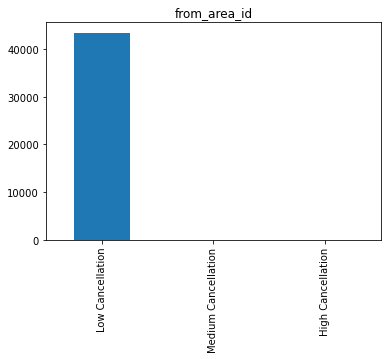

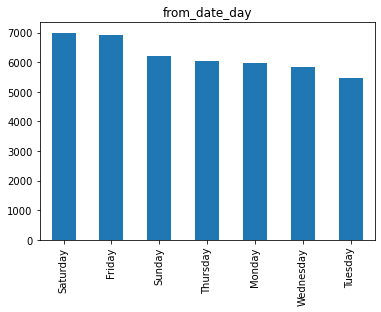

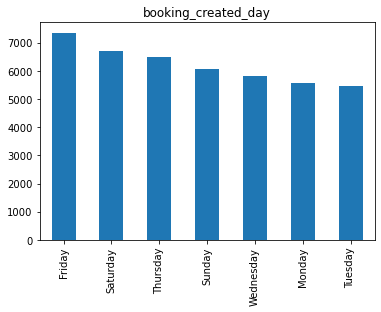

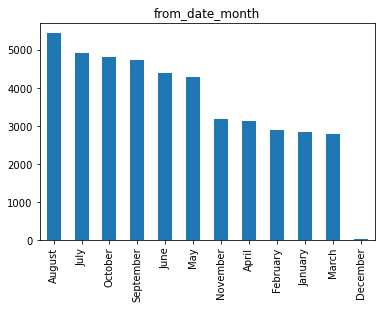

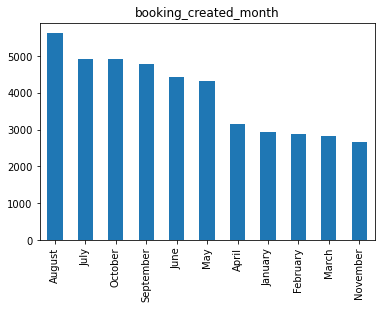

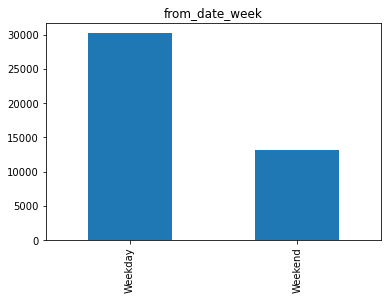

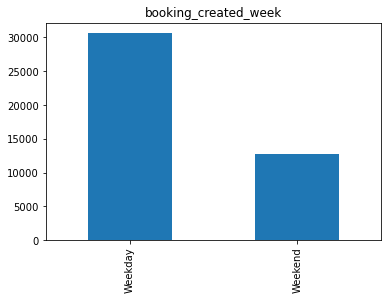

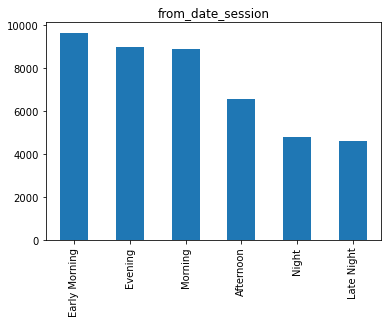

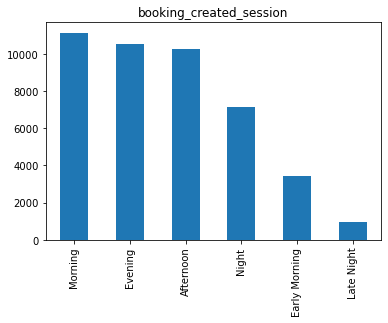

In [45]:
for col in data.columns:
  if data[col].dtype == 'object':
    data[col].value_counts().plot.bar()
    plt.title(col)
    plt.show()

#Data Encoding

In [46]:
num = data.select_dtypes(include='number')
char = data.select_dtypes(include='object')

In [47]:
num.head()

,online_booking,mobile_site_booking,traveltype_pointtopoint,traveltype_hourly,distance,time_diff
0,0,0,1,0,3.980687,21.0
1,0,0,1,0,14.004432,395.0
2,0,0,1,0,12.648909,22.0
3,0,0,1,0,9.534596,66.0
4,0,0,1,0,14.655467,67.0


In [48]:
char.head()

,from_area_id,from_date_day,booking_created_day,from_date_month,booking_created_month,from_date_week,booking_created_week,from_date_session,booking_created_session
0,Low Cancellation,Tuesday,Tuesday,January,January,Weekday,Weekday,Late Night,Late Night
1,Low Cancellation,Tuesday,Tuesday,January,January,Weekday,Weekday,Morning,Late Night
2,Low Cancellation,Tuesday,Tuesday,January,January,Weekday,Weekday,Late Night,Late Night
3,Low Cancellation,Tuesday,Tuesday,January,January,Weekday,Weekday,Early Morning,Late Night
4,Low Cancellation,Tuesday,Tuesday,January,January,Weekday,Weekday,Morning,Early Morning


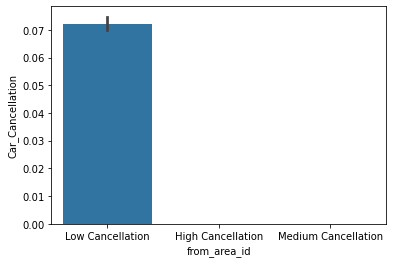

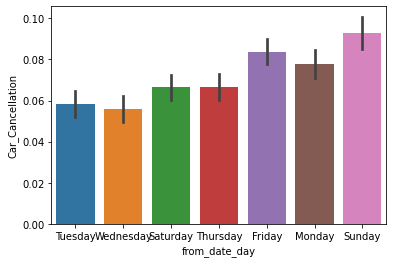

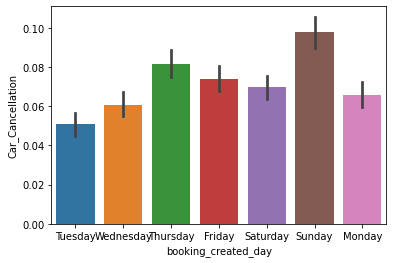

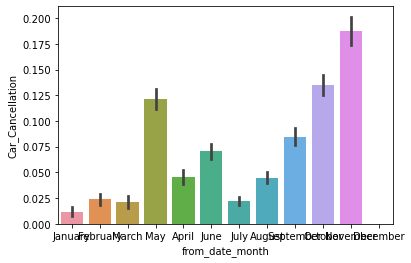

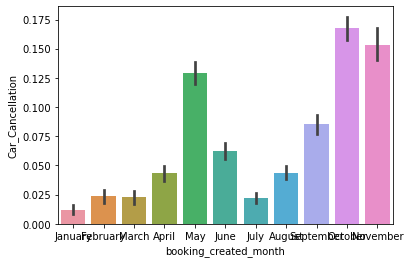

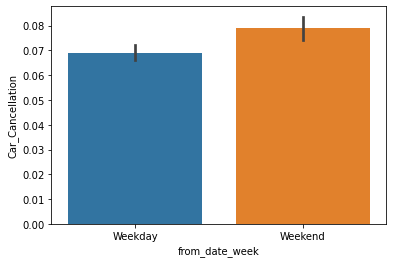

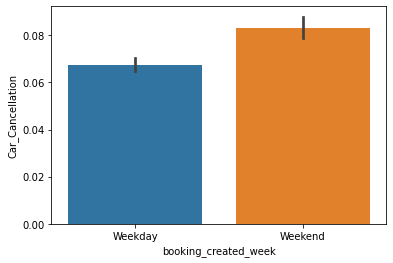

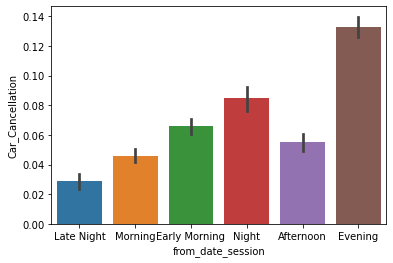

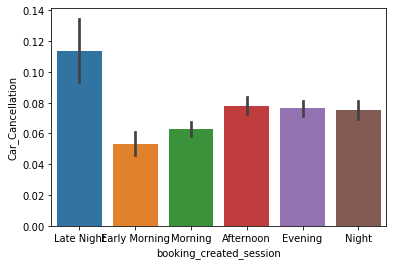

In [49]:
X_char_merged = pd.concat([char,target],axis=1,join='inner')

from numpy import mean
for col in (char.columns):
    plt.figure()
    sns.barplot(x=col,y='Car_Cancellation',data=X_char_merged,estimator=mean)
plt.show()

In [50]:
X_char_dum = pd.get_dummies(char, drop_first = True)
X_char_dum.shape

(43431, 47)

In [51]:
X_char_dum.head()

,from_area_id_Low Cancellation,from_area_id_Medium Cancellation,from_date_day_Monday,from_date_day_Saturday,from_date_day_Sunday,from_date_day_Thursday,from_date_day_Tuesday,from_date_day_Wednesday,booking_created_day_Monday,booking_created_day_Saturday,...,from_date_session_Early Morning,from_date_session_Evening,from_date_session_Late Night,from_date_session_Morning,from_date_session_Night,booking_created_session_Early Morning,booking_created_session_Evening,booking_created_session_Late Night,booking_created_session_Morning,booking_created_session_Night
0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [52]:
data_all = pd.concat([num,X_char_dum],axis=1,join='inner')

In [53]:
data_all.head()

,online_booking,mobile_site_booking,traveltype_pointtopoint,traveltype_hourly,distance,time_diff,from_area_id_Low Cancellation,from_area_id_Medium Cancellation,from_date_day_Monday,from_date_day_Saturday,...,from_date_session_Early Morning,from_date_session_Evening,from_date_session_Late Night,from_date_session_Morning,from_date_session_Night,booking_created_session_Early Morning,booking_created_session_Evening,booking_created_session_Late Night,booking_created_session_Morning,booking_created_session_Night
0,0,0,1,0,3.980687,21.0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,14.004432,395.0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0,0,1,0,12.648909,22.0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,1,0,9.534596,66.0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,0,1,0,14.655467,67.0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0


#Train Validation Split

In [54]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(data_all,target,test_size=0.3,random_state=1)

In [55]:
X_train.head()

,online_booking,mobile_site_booking,traveltype_pointtopoint,traveltype_hourly,distance,time_diff,from_area_id_Low Cancellation,from_area_id_Medium Cancellation,from_date_day_Monday,from_date_day_Saturday,...,from_date_session_Early Morning,from_date_session_Evening,from_date_session_Late Night,from_date_session_Morning,from_date_session_Night,booking_created_session_Early Morning,booking_created_session_Evening,booking_created_session_Late Night,booking_created_session_Morning,booking_created_session_Night
21506,0,0,1,0,9.236426,2832.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12367,0,1,1,0,1.809583,1504.0,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
5983,0,0,1,0,13.558000,214.0,1,0,0,1,...,0,0,0,0,1,0,1,0,0,0
18513,0,0,0,0,18.456702,37.0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
16033,1,0,1,0,13.405912,128.0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [56]:
X_val.head()

,online_booking,mobile_site_booking,traveltype_pointtopoint,traveltype_hourly,distance,time_diff,from_area_id_Low Cancellation,from_area_id_Medium Cancellation,from_date_day_Monday,from_date_day_Saturday,...,from_date_session_Early Morning,from_date_session_Evening,from_date_session_Late Night,from_date_session_Morning,from_date_session_Night,booking_created_session_Early Morning,booking_created_session_Evening,booking_created_session_Late Night,booking_created_session_Morning,booking_created_session_Night
26610,0,0,0,1,3.417640,208.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
38515,0,0,0,1,4.104127,69.0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
29806,0,1,0,1,11.849498,457.0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
28868,0,0,0,1,8.116004,2371.0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
11163,1,0,1,0,27.427907,444.0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


#Model Selection

In [57]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=4)
lr.fit(X_train,y_train)

C:\Users\dell\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=4)

In [58]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='gini',random_state=4)

In [59]:
from sklearn.model_selection import GridSearchCV
param_dist = {'max_depth': [3, 5, 6, 7], 'min_samples_split': [50, 100, 150, 200, 250]}
gscv_dtc = GridSearchCV(dtc, cv=10, param_grid=param_dist, n_jobs=-1)
gscv_dtc.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=4), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7],
                         'min_samples_split': [50, 100, 150, 200, 250]})

In [60]:
gscv_dtc.best_params_

{'max_depth': 7, 'min_samples_split': 50}

In [61]:
dtc=DecisionTreeClassifier(criterion='gini',random_state=4,max_depth=7,min_samples_split=50)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=7, min_samples_split=50, random_state=4)

In [62]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion='gini',random_state=4)

In [63]:
from sklearn.model_selection import GridSearchCV
param_dist = {'max_depth': [3, 5, 6, 7], 'min_samples_split': [50, 100, 150, 200, 250]}
gscv_rfc = GridSearchCV(rfc, cv=10, param_grid=param_dist, n_jobs=-1)
gscv_rfc.fit(X_train,y_train)

C:\Users\dell\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=4), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7],
                         'min_samples_split': [50, 100, 150, 200, 250]})

In [64]:
gscv_rfc.best_params_

{'max_depth': 7, 'min_samples_split': 50}

In [65]:
rfc=RandomForestClassifier(criterion='gini',random_state=4,max_depth=7,min_samples_split=50)
rfc.fit(X_train,y_train)

<ipython-input-65-0349835b89f6>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,y_train)


RandomForestClassifier(max_depth=7, min_samples_split=50, random_state=4)

#Model Evaluation

In [66]:
y_pred_lr=lr.predict(X_val)
y_pred_dtc=dtc.predict(X_val)
y_pred_rfc=rfc.predict(X_val)

In [67]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [68]:
print("Accuracy:",metrics.accuracy_score(y_val, y_pred_lr))
print("Precision",metrics.precision_score(y_val,y_pred_lr))
print("Recall",metrics.recall_score(y_val,y_pred_lr))
print("f1_score",metrics.f1_score(y_val,y_pred_lr))

Accuracy: 0.929623944742901
Precision 0.5581395348837209
Recall 0.07725321888412018
f1_score 0.1357210179076343


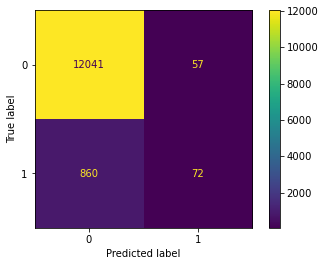

In [69]:
metrics.plot_confusion_matrix(lr,X_val,y_val)

In [70]:
print("Accuracy:",metrics.accuracy_score(y_val, y_pred_dtc))
print("Precision",metrics.precision_score(y_val,y_pred_dtc))
print("Recall",metrics.recall_score(y_val,y_pred_dtc))
print("f1_score",metrics.f1_score(y_val,y_pred_dtc))

Accuracy: 0.9323100537221796
Precision 0.6865671641791045
Recall 0.09871244635193133
f1_score 0.1726078799249531


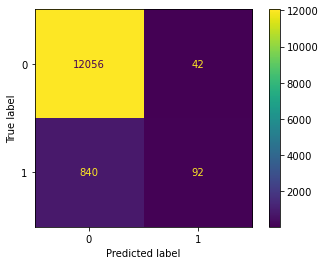

In [71]:
metrics.plot_confusion_matrix(dtc,X_val,y_val)

In [72]:
print("Accuracy:",metrics.accuracy_score(y_val, y_pred_rfc))
print("Precision",metrics.precision_score(y_val,y_pred_rfc))
print("Recall",metrics.recall_score(y_val,y_pred_rfc))
print("f1_score",metrics.f1_score(y_val,y_pred_rfc))

Accuracy: 0.930775134305449
Precision 1.0
Recall 0.032188841201716736
f1_score 0.06237006237006236


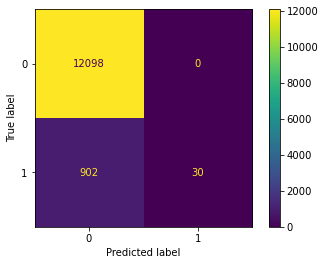

In [73]:
metrics.plot_confusion_matrix(rfc,X_val,y_val)